In [7]:
import torch
import transformers
from transformers import AutoModelWithLMHead, PreTrainedTokenizerFast
from fastai.text.all import *
import fastai
import re

print(torch.__version__)
print(transformers.__version__)
print( fastai.__version__)

1.7.1+cu110
4.10.2
2.4


In [8]:
#download model and tokenizer
tokenizer = PreTrainedTokenizerFast.from_pretrained("skt/kogpt2-base-v2",
  bos_token='</s>', eos_token='</s>', unk_token='<unk>',
  pad_token='<pad>', mask_token='<mask>') 
model = AutoModelWithLMHead.from_pretrained("skt/kogpt2-base-v2")

#test tokenizer
print(tokenizer.tokenize("안녕하세요. 한국어 GPT-2 입니다.😤:)l^o"))

#test model ouput
text = """위치추적 전자장치(전자발찌) 훼손 전후로 여성 2명을 잇달아 살해한 """
input_ids = tokenizer.encode(text)
gen_ids = model.generate(torch.tensor([input_ids]),
                           max_length=128,
                           repetition_penalty=2.0,
                           pad_token_id=tokenizer.pad_token_id,
                           eos_token_id=tokenizer.eos_token_id,
                           bos_token_id=tokenizer.bos_token_id,
                           use_cache=True
                        )
generated = tokenizer.decode(gen_ids[0,:].tolist())
print(generated)

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'GPT2Tokenizer'. 
The class this function is called from is 'PreTrainedTokenizerFast'.


['▁안녕', '하', '세', '요.', '▁한국어', '▁G', 'P', 'T', '-2', '▁입', '니다.', '😤', ':)', 'l^o']
위치추적 전자장치(전자발찌) 훼손 전후로 여성 2명을 잇달아 살해한 ᄋ씨(33)에 대해 구속영장을 신청했다.
경찰에 따르면 ᄀ씨는 지난달 29일 오후 9시30분쯤 서울 강남구 논현동 자신의 집에서 ᄂ씨를 흉기로 찔러 숨지게 한 혐의를 받고 있다.
ᄀ씨의 범행은 B씨가 “여자친구가 있다”며 경찰에 신고하면서 드러났다.
B씨도 같은 날 오전 10시경 경찰서에 자진출석해 조사를 받았다.
ᄂ씨와 함께 있던 ᄃ(31·여)은 이날 새벽 1시까지 조사에서 “내가 여자 친구와 사귀고 있어 괴롭다”고 진술했다.</d> 부산시는 오는 10월까지 '부산형


In [9]:
with open('text_data.txt') as f:
    lines = f.read()
lines=" ".join(lines.split())
len(lines)

2744438

In [10]:
lines=re.sub('\(계속\).*?[●○]', '', lines)
lines=re.sub('[●○]', '', lines)
len(lines)

2422896

In [11]:
#model input output tokenizer
class TransformersTokenizer(Transform):
    def __init__(self, tokenizer): self.tokenizer = tokenizer
    def encodes(self, x): 
        toks = self.tokenizer.tokenize(x)
        return tensor(self.tokenizer.convert_tokens_to_ids(toks))
    def decodes(self, x): return TitledStr(self.tokenizer.decode(x.cpu().numpy()))

#split data
train=lines[:int(len(lines)*0.9)]
test=lines[int(len(lines)*0.9):]
splits = [[0],[1]]

#init dataloader
tls = TfmdLists([train,test], TransformersTokenizer(tokenizer), splits=splits, dl_type=LMDataLoader)
batch,seq_len = 8,256
dls = tls.dataloaders(bs=batch, seq_len=seq_len)
# dls.show_batch(max_n=2)

SuggestedLRs(valley=tensor(1.7378e-05))


epoch,train_loss,valid_loss,perplexity,time
0,3.534882,3.688004,39.964989,01:55
1,3.260040,3.587380,36.139263,01:55
2,3.086436,3.552240,34.891392,01:55
3,2.974506,3.527494,34.038567,01:55
4,2.925448,3.523227,33.893635,01:55


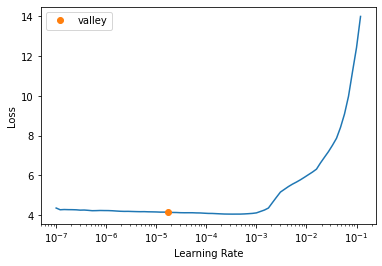

In [12]:
#gpt2 ouput is tuple, we need just one val
class DropOutput(Callback):
    def after_pred(self): self.learn.pred = self.pred[0]
        
        
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), cbs=[DropOutput], metrics=Perplexity()).to_fp16()
lr=learn.lr_find()
print(lr)
learn.fit_one_cycle(5, lr)
# learn.fine_tune(3)

In [15]:
prompt="위치추적 전자장치(전자발찌) 훼손 전후로 여성 2명을 잇달아 살해한 "
prompt_ids = tokenizer.encode(prompt)
inp = tensor(prompt_ids)[None].cuda()
preds = learn.model.generate(inp,
                           max_length=128,
                           pad_token_id=tokenizer.pad_token_id,
                           eos_token_id=tokenizer.eos_token_id,
                           bos_token_id=tokenizer.bos_token_id,
                           repetition_penalty=2.0,       
                           use_cache=True
                          ) 
tokenizer.decode(preds[0].cpu().numpy())



'위치추적 전자장치(전자발찌) 훼손 전후로 여성 2명을 잇달아 살해한 녀석이었다. “야, 조아영. 너 왜 그래?” “아니야...! 그건 니가 잘못했어...” 아영이에게 모욕당한 여자애들은, 그녀의 말을 듣고는 크게 놀라며 고개를 숙였다. “그럼 이제부터 어떻게 할 거냐고 물어봐도 돼요?” “어차피 우리 반 애들한테까지 다 들었으니까 얘기해 줄 수 있을 것 같네요.” 지은이는 말꼬리를 흐렸다. “이제부터는 내가 알아서 해라. 알았지? 그럼 내일 다시 만나자!” 예'

In [ ]:
learn.model.save_pretrained("kogpt2novel_backup")
model.push_to_hub("kogpt2novel")
tokenizer.push_to_hub("kogpt2novel")